In [78]:
import logging, os
logging.disable(logging.WARNING)
logging.disable(logging.INFO)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, \
    RandomFlip, RandomRotation,GlobalMaxPooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

In [80]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH  = 160

TRAIN_PATH = "C:\\Users\\loure\\1 ISCTE\\cats_and_dogs\\train"
VALIDATION_PATH = "C:\\Users\\loure\\1 ISCTE\\cats_and_dogs\\validation"
TEST_PATH = "C:\\Users\\loure\\1 ISCTE\\cats_and_dogs\\test"
TEST_SAMPLES = 500 

NUM_CLASSES = 2

# Building the datasets needed
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

labels = test_ds.class_names

train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

print(labels)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
['cats', 'dogs']


In [84]:
resNet50_model = ResNet50(include_top=False, pooling='max', weights='imagenet')
resNet50_model.trainable = False

# Create the CNN model
model = tf.keras.models.Sequential([
    layers.Rescaling(2./255, offset=-1, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resNet50_model,
       
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.layers[0].trainable = True
# Model loss function and Adam optimizer with learning rate of 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_52 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [85]:
EPOCHS  = 5
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/5
63/63 [==============================] - 57s 874ms/step - loss: 0.7434 - accuracy: 0.5815 - val_loss: 0.6441 - val_accuracy: 0.6400
Epoch 2/5
63/63 [==============================] - 56s 892ms/step - loss: 0.6164 - accuracy: 0.6450 - val_loss: 0.6534 - val_accuracy: 0.6480
Epoch 3/5
63/63 [==============================] - 59s 935ms/step - loss: 0.5868 - accuracy: 0.6740 - val_loss: 0.6453 - val_accuracy: 0.6560
Epoch 4/5
63/63 [==============================] - 55s 880ms/step - loss: 0.5637 - accuracy: 0.6960 - val_loss: 0.6416 - val_accuracy: 0.6580
Epoch 5/5
63/63 [==============================] - 57s 901ms/step - loss: 0.5456 - accuracy: 0.7085 - val_loss: 0.6408 - val_accuracy: 0.6600


16/16 [==============================] - 11s 662ms/step


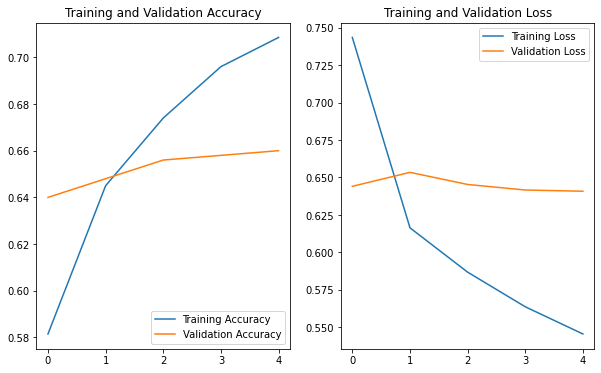

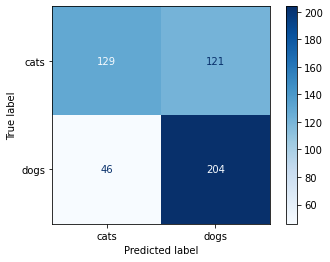

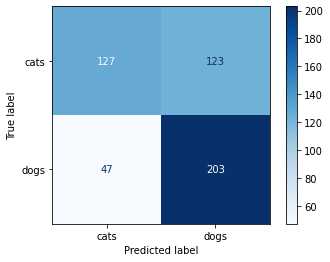


Falhou 167 de 500 exemplos
Taxa de acertos: 66.60%


In [86]:
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat([y for x, y in test_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

y_pred1 = model.predict(val_ds)
y_pred1 = tf.argmax(y_pred1, axis=1)

y_true1 = tf.concat([y for x, y in val_ds], axis=0)
y_true1 = tf.argmax(y_true1, axis=1)

# gerar graficos e matriz de confusao
cm = confusion_matrix(y_true, y_pred)
cm1 = confusion_matrix(y_true1, y_pred1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# calcular acertos no conjunto de teste
misses = np.count_nonzero(y_true-y_pred)
accuracy = (TEST_SAMPLES - misses) / TEST_SAMPLES

print(f"\nFalhou {misses} de {TEST_SAMPLES} exemplos")
print(f"Taxa de acertos: {(accuracy*100):.2f}%")